<a href="https://colab.research.google.com/github/kabraxis/Unsupervised-Domain-Adaptation-with-BERT/blob/master/Predicting_Amazon_Stars_with_BERT_on_TF_Hub_via_low_level_TF_and_domain_discriminator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Copyright 2019 Google Inc.

# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at

#     http://www.apache.org/licenses/LICENSE-2.0

# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

#Amazon Food Review Sentiment with BERT


In [0]:
from sklearn.model_selection import train_test_split
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
from datetime import datetime
from sklearn.model_selection import train_test_split
from BERToptimizer import create_optimizer
from random import shuffle
from tensorflow.python.framework import ops

W0730 11:37:11.052289 139921088538496 deprecation_wrapper.py:119] From /content/BERToptimizer.py:90: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In addition to the standard libraries we imported above, we'll need to install BERT's python package.

In [0]:
!pip install bert-tensorflow

     |████████████████████████████████| 71kB 2.3MB/s 


In [0]:
import bert
from bert import run_classifier
from bert import optimization
from bert import tokenization

In [0]:
# Set the output directory for saving model file
# Optionally, set a GCP bucket location

OUTPUT_DIR = 'bert_domain_adapt'#@param {type:"string"}
#@markdown Whether or not to clear/delete the directory and create a new one
DO_DELETE = True #@param {type:"boolean"}
#@markdown Set USE_BUCKET and BUCKET if you want to (optionally) store model output on GCP bucket.
USE_BUCKET = False #@param {type:"boolean"}
BUCKET = '' #@param {type:"string"}

if USE_BUCKET:
  OUTPUT_DIR = 'gs://{}/{}'.format(BUCKET, OUTPUT_DIR)
  from google.colab import auth
  auth.authenticate_user()

if DO_DELETE:
  try:
    tf.gfile.DeleteRecursively(OUTPUT_DIR)
  except:
    # Doesn't matter if the directory didn't exist
    pass
tf.gfile.MakeDirs(OUTPUT_DIR)
print('***** Model output directory: {} *****'.format(OUTPUT_DIR))


***** Model output directory: bert_domain_adapt *****


#Data

In [0]:
from sklearn.model_selection import train_test_split
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
from datetime import datetime
import os
import re
import pandas as pd 
import gzip 
import numpy as np

def split_d(dataset):
    dataset.columns = ['reviewerID', 'asin', 'reviewerName', 'helpful', 'sentence',
           'sentiment', 'summary', 'unixReviewTime', 'reviewTime']
    dataset["sentiment"] = dataset["sentiment"].astype(np.int64)-1 
    def convert_to_three(value):
      if value == 0 or value == 1:
        return 0
      elif value == 2:
        return 1
      elif value == 3 or value == 4:
        return 2
    dataset["sentiment"] = dataset["sentiment"].map(convert_to_three)
    dataset = dataset.sample(frac=1).reset_index(drop=True)

    dp_train,dp_test = train_test_split(dataset,test_size=0.2)
    return dp_train,dp_test 

# Open the gz file and read each entry as dictionary
def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
         yield eval(l) 

# Add the data entries to a pandas frame
def getDF(path):
    i = 0 
    df = {}
    for d in parse(path):
         df[i] = d 
         i += 1
    return pd.DataFrame.from_dict(df, orient='index')

# Download the data and return its local path
def download_and_load_datasets(origin="http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Home_and_Kitchen_5.json.gz"):
  ff = origin.split("/")[-1]
  dataset = tf.keras.utils.get_file(
      fname=ff,
      origin=origin, 
      extract=False)

  return dataset

dp_train,dp_test = split_d(getDF(download_and_load_datasets()))

138133504/138126598 [==============================] - 25s 0us/step


To keep training fast, we'll take a sample of 5000 train and test examples, respectively.

In [0]:
#Source Dataset
#TODO: add validation split
dp_train = dp_train.sample(60000)
dp_test = dp_test.sample(7500)

In [0]:
#Make number of samples per class equal
dp_train = dp_train.groupby('sentiment')
dp_train = dp_train.apply(lambda x: x.sample(dp_train.size().min()).reset_index(drop=True))
dp_train = dp_train.sample(frac=1).reset_index(drop=True) #shuffle again

In [0]:
#Target dataset
#TODO: add validation and test split
domain_adapt_train,domain_adapt_test = split_d(getDF(download_and_load_datasets("http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Grocery_and_Gourmet_Food_5.json.gz")))
domain_adapt_train = domain_adapt_train.sample(dp_train.shape[0])
domain_adapt_test  = domain_adapt_test.sample(7500)

36765696/36760767 [==============================] - 10s 0us/step


For us, our input data is the 'sentence' column and our label is the 'polarity' column (0, 1 for negative and positive, respecitvely)

In [0]:
DATA_COLUMN = 'sentence'
LABEL_COLUMN = 'sentiment'
# label_list is the list of labels, i.e. True, False or 0, 1 or 'dog', 'cat'
label_list = [0, 1, 2]

#Data Preprocessing


In [0]:
# Use the InputExample class from BERT's run_classifier code to create examples from the data
train_InputExamples = dp_train.apply(lambda x: bert.run_classifier.InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this example
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)

test_InputExamples = dp_test.apply(lambda x: bert.run_classifier.InputExample(guid=None, 
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)
domaintest_InputExample = domain_adapt_test.apply(lambda x: bert.run_classifier.InputExample(guid=None, 
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)
domaintrain_InputExample = domain_adapt_train.apply(lambda x: bert.run_classifier.InputExample(guid=None, 
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)

In [0]:
# This is a path to an uncased (all lowercase) version of BERT
BERT_MODEL_HUB = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"

def create_tokenizer_from_hub_module():
  """Get the vocab file and casing info from the Hub module."""
  with tf.Graph().as_default():
    bert_module = hub.Module(BERT_MODEL_HUB)
    tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
    with tf.Session() as sess:
      vocab_file, do_lower_case = sess.run([tokenization_info["vocab_file"],
                                            tokenization_info["do_lower_case"]])
      
  return bert.tokenization.FullTokenizer(
      vocab_file=vocab_file, do_lower_case=do_lower_case)

tokenizer = create_tokenizer_from_hub_module()

W0730 11:38:59.575024 139921088538496 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/bert/tokenization.py:125: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.



In [0]:
#TODO: Apply these on other splits as well
# We'll set sequences to be at most 128 tokens long.
MAX_SEQ_LENGTH = 100 #128
# Convert our train and test features to InputFeatures that BERT understands.
train_features = bert.run_classifier.convert_examples_to_features(train_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)
test_features = bert.run_classifier.convert_examples_to_features(test_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)
domain_test_features = bert.run_classifier.convert_examples_to_features(domaintest_InputExample, label_list, MAX_SEQ_LENGTH, tokenizer)
domain_train_features = bert.run_classifier.convert_examples_to_features(domaintrain_InputExample, label_list, MAX_SEQ_LENGTH, tokenizer)

W0730 11:38:59.724204 139921088538496 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/bert/run_classifier.py:774: The name tf.logging.info is deprecated. Please use tf.compat.v1.logging.info instead.



In [0]:
#TODO: make this not on all data, but on a single batch
#TODO: apply this on the other data as well, make it more neat.

all_tra_input_ids = []
all_tra_input_mask = []
all_tra_segment_ids = []
all_tra_label_ids = []

for feature in train_features:
    all_tra_input_ids.append(feature.input_ids)
    all_tra_input_mask.append(feature.input_mask)
    all_tra_segment_ids.append(feature.segment_ids)
    all_tra_label_ids.append(feature.label_id)

all_test_input_ids = []
all_test_input_mask = []
all_test_segment_ids = []
all_test_label_ids = []

for feature in test_features:
    all_test_input_ids.append(feature.input_ids)
    all_test_input_mask.append(feature.input_mask)
    all_test_segment_ids.append(feature.segment_ids)
    all_test_label_ids.append(feature.label_id)

all_domaintest_input_ids = []
all_domaintest_input_mask = []
all_domaintest_segment_ids = []
all_domaintest_label_ids = []

for feature in domain_test_features:
    all_domaintest_input_ids.append(feature.input_ids)
    all_domaintest_input_mask.append(feature.input_mask)
    all_domaintest_segment_ids.append(feature.segment_ids)
    all_domaintest_label_ids.append(feature.label_id)
    
all_domaintrain_input_ids = []
all_domaintrain_input_mask = []
all_domaintrain_segment_ids = []
all_domaintrain_label_ids = []

for feature in domain_train_features:
    all_domaintrain_input_ids.append(feature.input_ids)
    all_domaintrain_input_mask.append(feature.input_mask)
    all_domaintrain_segment_ids.append(feature.segment_ids)
    all_domaintrain_label_ids.append(feature.label_id)
    
   

#Creating a model

Now that we've prepared our data, let's focus on building a model. `create_model` does just this below. First, it loads the BERT tf hub module again (this time to extract the computation graph). Next, it creates a single new layer that will be trained to adapt BERT to our sentiment task (i.e. classifying whether a movie review is positive or negative). This strategy of using a mostly trained model is called [fine-tuning](http://wiki.fast.ai/index.php/Fine_tuning).

In [0]:
# Compute train and warmup steps from batch size
BATCH_SIZE = 24
LEARNING_RATE = 2e-6
NUM_TRAIN_EPOCHS = 15
N_SAMPLE = len(all_tra_input_ids)
SHUFFLE = True
# Warmup is a period of time where hte learning rate 
# is small and gradually increases--usually helps training.
WARMUP_PROPORTION = 0.1
# Model configs
SAVE_CHECKPOINTS_STEPS = 500
SAVE_SUMMARY_STEPS = 100

adversarial_lambda = 0.6

num_train_steps = int(len(train_features) / BATCH_SIZE * NUM_TRAIN_EPOCHS)
n_batch = int((N_SAMPLE-1) / BATCH_SIZE)
n_test = int((len(all_test_input_ids)-1) / BATCH_SIZE)
n_domain = int((len(all_domaintest_input_ids)-1) / BATCH_SIZE)
num_warmup_steps = 0# int(num_train_steps * WARMUP_PROPORTION)
num_labels = len(label_list)

In [0]:
with tf.name_scope('input'):
  input_ids = tf.placeholder(tf.int32,shape=(None, MAX_SEQ_LENGTH))
  input_mask = tf.placeholder(tf.int32,shape=(None, MAX_SEQ_LENGTH))
  segment_ids = tf.placeholder(tf.int32,shape=(None, MAX_SEQ_LENGTH))
  labels_true = tf.placeholder(tf.int32,shape=(None,))
  train_flag = tf.placeholder(dtype=tf.bool)
  label_one_hot = tf.one_hot(labels_true, num_labels, dtype=tf.float32)
    
bert_module = hub.Module(
      BERT_MODEL_HUB,
      trainable=True)
bert_inputs = dict(
      input_ids=input_ids,
      input_mask=input_mask,
      segment_ids=segment_ids)
bert_outputs = bert_module(
      inputs=bert_inputs,
      signature="tokens",
      as_dict=True)

output_layer = bert_outputs["pooled_output"]

hidden_size = output_layer.shape[-1].value

#variables_to_restore_BERT = [var for var in bert_module.variables if not "/cls/" in var.name]
variables_to_restore_BERT = bert_module.variables
loader =  tf.contrib.framework.assign_from_checkpoint_fn(
    "./uncased_L-12_H-768_A-12/bert_model.ckpt",
    variables_to_restore_BERT
)


W0730 11:40:42.648287 139921088538496 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [0]:
with tf.name_scope('slice_features'):
    bert_outputs_source = tf.cond(train_flag, lambda: tf.slice(output_layer, [0, 0], [int(BATCH_SIZE), -1]), lambda: output_layer) #Use in class task
    
with tf.variable_scope('domain_discriminator'):
    #TODO: Check gradient reversal
    disc_l1 = tf.layers.dense(inputs=output_layer, units=100, activation=tf.nn.relu) #TODO: reduce number of units
    #disc_l1 = tf.layers.dropout(inputs=disc_l1, rate=0.4, training=train_flag)
    
    disc_outs = tf.layers.dense(inputs=disc_l1, units=1)

with tf.name_scope('slice_discriminator'):   
    disc_outs_source = tf.cond(train_flag, lambda: tf.slice(disc_outs, [0, 0], [int(BATCH_SIZE), -1]), lambda: disc_outs) #Use in discriminator task
    disc_outs_target = tf.cond(train_flag, lambda: tf.slice(disc_outs, [int(BATCH_SIZE), 0], [int(BATCH_SIZE), -1]), lambda: disc_outs)
    
    
with tf.variable_scope("sent_class"):
    # Create our own layer to tune for sentiment analysis.
    output_weights = tf.get_variable(
          "output_weights", [num_labels, hidden_size],
          initializer=tf.truncated_normal_initializer(stddev=0.02))

    output_bias = tf.get_variable(
          "output_bias", [num_labels], initializer=tf.zeros_initializer())

    logits = tf.matmul(bert_outputs_source, output_weights, transpose_b=True)
    logits = tf.nn.bias_add(logits, output_bias)
    log_probs = tf.nn.log_softmax(logits, axis=-1)

    predicted_labels = tf.squeeze(tf.argmax(log_probs, axis=-1, output_type=tf.int32))
    
with tf.variable_scope("loss"):
    # If we're train/eval, compute loss between predicted and actual label
    per_example_loss = -tf.reduce_sum(label_one_hot * log_probs, axis=-1)
    class_loss = tf.reduce_mean(per_example_loss)
        
    disc_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_outs_source,labels=tf.ones_like(disc_outs_source))
                               + tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_outs_target,labels=tf.zeros_like(disc_outs_target)))
    
    #Adverserial loss is just the inverse of it
    adverserial_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_outs_source,labels=tf.zeros_like(disc_outs_source))
                               + tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_outs_target,labels=tf.ones_like(disc_outs_target))) 

    total_loss = class_loss + adversarial_lambda * adverserial_loss

W0730 11:40:43.027811 139921088538496 deprecation.py:323] From <ipython-input-18-93a01b22e5fa>:8: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dense instead.
W0730 11:40:43.043049 139921088538496 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0730 11:40:43.861220 139921088538496 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast

In [0]:
bert_vars = [var for var in tf.trainable_variables() if (not "/cls/" in var.name) and ("bert" in var.name)]
class_vars = [var for var in tf.trainable_variables() if "sent_class" in var.name]
class_train_op = create_optimizer(total_loss, LEARNING_RATE, num_train_steps, num_warmup_steps, bert_vars+class_vars, use_tpu=False)

disc_vars = [var for var in tf.trainable_variables() if 'domain_discriminator' in var.name]
disc_train_op =  tf.train.AdamOptimizer(learning_rate=LEARNING_RATE,epsilon=1e-6).minimize(disc_loss,var_list=disc_vars)

equality = tf.equal(predicted_labels, labels_true)
accuracy = tf.reduce_mean(tf.cast(equality, tf.float32))

target_acc = []
source_acc = []

target_loss = []
source_loss = []

train_class_loss = []
train_adv_loss = []

with tf.Session() as sess:
  sess.run([tf.global_variables_initializer(), tf.local_variables_initializer()])

  for j in range(NUM_TRAIN_EPOCHS):
    if SHUFFLE:
        indices = np.arange(N_SAMPLE)
        np.random.shuffle(indices)
        all_tra_input_ids = np.array(all_tra_input_ids)[indices.astype(int)]
        all_tra_input_mask = np.array(all_tra_input_mask)[indices.astype(int)]
        all_tra_segment_ids = np.array(all_tra_segment_ids)[indices.astype(int)]
        all_tra_label_ids = np.array(all_tra_label_ids)[indices.astype(int)]

        all_domaintrain_input_ids = np.array(all_domaintrain_input_ids)[indices.astype(int)]
        all_domaintrain_input_mask = np.array(all_domaintrain_input_mask)[indices.astype(int)]
        all_domaintrain_segment_ids = np.array(all_domaintrain_segment_ids)[indices.astype(int)]
        
    for i in range(n_batch):
          start = i * BATCH_SIZE
          end = min(N_SAMPLE, start + BATCH_SIZE)
          lss,dlss,acc, _ = sess.run([class_loss,disc_loss,accuracy,class_train_op], feed_dict={input_ids: np.vstack((all_tra_input_ids[start:end], all_domaintrain_input_ids[start:end])),
                                          input_mask: np.vstack((all_tra_input_mask[start:end], all_domaintrain_input_mask[start:end])),
                                          segment_ids: np.vstack((all_tra_segment_ids[start:end],all_domaintrain_segment_ids[start:end])),
                                          labels_true: all_tra_label_ids[start:end],
                                          train_flag: True})
          train_class_loss.append(lss)
          train_adv_loss.append(dlss)
          
          if adversarial_lambda > 0.0:
            for _ in range(5):
                sess.run([disc_train_op], feed_dict={input_ids: np.vstack((all_tra_input_ids[start:end], all_domaintrain_input_ids[start:end])),
                                            input_mask: np.vstack((all_tra_input_mask[start:end], all_domaintrain_input_mask[start:end])),
                                            segment_ids: np.vstack((all_tra_segment_ids[start:end],all_domaintrain_segment_ids[start:end])),
                                            train_flag: True})
              
          if (int(len(train_features) / BATCH_SIZE)*j+i+1)%150==0:
              test_accs = []
              test_loss = []
              for k in range(n_test):
                  start = k * BATCH_SIZE
                  end = min(len(all_test_input_ids), start + BATCH_SIZE)
                  test_lss,test_acc = sess.run([class_loss,accuracy], feed_dict={input_ids: all_test_input_ids[start:end], 
                                                  input_mask: all_test_input_mask[start:end],
                                                  segment_ids: all_test_segment_ids[start:end],
                                                  labels_true: all_test_label_ids[start:end],
                                                  train_flag: False})
                  test_accs.append(test_acc)
                  test_loss.append(test_lss)
              print("iter: {}, train_loss: {}, train_accuracy:  {},   val_loss: {}, val_accuracy:  {}".format((int(len(train_features) / BATCH_SIZE)*j+i+1),lss,acc,np.mean(test_loss),np.mean(test_accs)))
              source_acc.append(np.mean(test_accs))
              source_loss.append(np.mean(test_loss))
              
              domaintest_accs = []
              domaintest_loss = []
              for k in range(n_domain):
                    start = k * BATCH_SIZE
                    end = min(len(all_domaintest_input_ids), start + BATCH_SIZE)
                    domaintest_lss,domaintest_acc = sess.run([class_loss,accuracy], feed_dict={input_ids: all_domaintest_input_ids[start:end], 
                                                       input_mask: all_domaintest_input_mask[start:end],
                                                       segment_ids: all_domaintest_segment_ids[start:end],
                                                       labels_true: all_domaintest_label_ids[start:end],
                                                       train_flag: False})
                    domaintest_accs.append(domaintest_acc)
                    domaintest_loss.append(domaintest_lss) 
              print("iter:  {}, domaintest_loss   {},   domaintest_accuracy:   {}".format((int(len(train_features) / BATCH_SIZE)*j+i+1),np.mean(domaintest_loss),np.mean(domaintest_accs)))
              target_acc.append(np.mean(domaintest_accs))
              target_loss.append(np.mean(domaintest_loss))

W0730 11:40:44.033113 139921088538496 deprecation_wrapper.py:119] From /content/BERToptimizer.py:30: The name tf.train.get_or_create_global_step is deprecated. Please use tf.compat.v1.train.get_or_create_global_step instead.

W0730 11:40:44.045650 139921088538496 deprecation_wrapper.py:119] From /content/BERToptimizer.py:35: The name tf.train.polynomial_decay is deprecated. Please use tf.compat.v1.train.polynomial_decay instead.

W0730 11:40:44.058302 139921088538496 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/optimizer_v2/learning_rate_schedule.py:409: div (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
W0730 11:40:49.432756 139921088538496 deprecation_wrapper.py:119] From /content/BERToptimizer.py:120: The name tf.get_variable is deprecated. Please use tf.compat.v1.get_variable instead.

/usr/local/lib/python3.6/dist-pa

110184198
iter: 150, train_loss: 0.8841254115104675, train_accuracy:  0.5833333134651184,   val_loss: 0.7693772912025452, val_accuracy:  0.7429220080375671
iter:  150, domaintest_loss   0.9448233246803284,   domaintest_accuracy:   0.659588634967804
iter: 300, train_loss: 0.795632541179657, train_accuracy:  0.7083333134651184,   val_loss: 0.6763768196105957, val_accuracy:  0.7457265257835388
iter:  300, domaintest_loss   1.0175817012786865,   domaintest_accuracy:   0.4309562146663666
iter: 450, train_loss: 0.9472665190696716, train_accuracy:  0.5833333134651184,   val_loss: 0.6440836787223816, val_accuracy:  0.7544070482254028
iter:  450, domaintest_loss   0.988447904586792,   domaintest_accuracy:   0.48450857400894165
iter: 600, train_loss: 0.6769124865531921, train_accuracy:  0.7083333134651184,   val_loss: 0.5864328742027283, val_accuracy:  0.7791132926940918
iter:  600, domaintest_loss   1.0255783796310425,   domaintest_accuracy:   0.4342948794364929
iter: 750, train_loss: 0.8618507

KeyboardInterrupt: ignored

In [0]:
np.save("test_accs.npy",source_acc)
np.save("test_loss.npy",source_loss)
np.save("target_accs.npy",target_acc)
np.save("target_loss.npy",target_loss)

In [0]:
import matplotlib.pyplot as plt
def plotAndSave(target,source,name="accuracy"):
    # Visualizes loss or accuracy between target and source datasets

    # Create count of the number of epochs
    epoch_count = range(1, len(source) + 1)

    # Visualize loss history
    plt.plot(epoch_count, source, 'r--')
    plt.plot(epoch_count, target, 'b-')
    plt.legend(['Classification ' + name, 'Adversarial ' + name])
    plt.xlabel('Epoch')
    plt.ylabel(name)
    plt.show


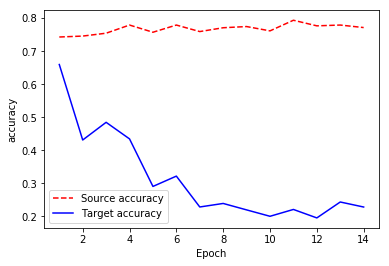

In [0]:
plotAndSave(target_acc,source_acc,'accuracy')

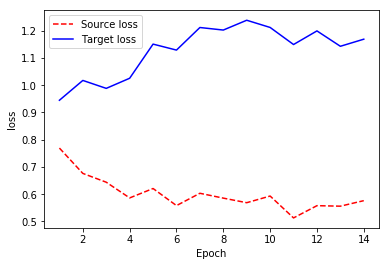

In [0]:
plotAndSave(target_loss,source_loss,'loss')

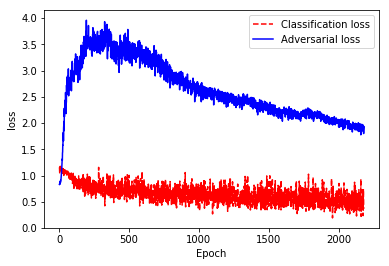

In [0]:
plotAndSave(np.array(train_adv_loss)*0.6,train_class_loss,'loss')